# Clase Práctica #9 (Compilación)

En esta clase estaremos implementando un **generador de lexer**. Nos apoyaremos en el intérprete de expresiones regulares que implementamos en la clase anterior.

Por cuestión de comodidad, en esta clase usaremos una versión de autómata basada en referencias entre estados.
La clase `State`, que usaremos para modelar los estados, se encuentra en `cmp.automata`. Pasemos a importala.

In [1]:
from cmp.automata import State

El autómata resulta de la interconexión de estados. Cualquier estado puede usarse como raíz del autómata, pero en función del estado que se escoja será el lenguaje reconocido. Un estado se contruye a partir de un objeto, que se usará para representarlo. Este puede ser un entero, o string, pero también pueden ser otros estados a su vez. Además, es necesario especificar si el estado es final o no. Por defecto se asume que **no** es final.

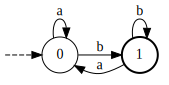

----------- Estado 0 -------------
Identificador: 0
Es final: False
Transiciones: {'a': [0], 'b': [1]}
Epsilon transiciones: set()


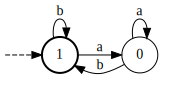

----------- Estado 1 -------------
Identificador: 1
Es final: True
Transiciones: {'a': [0], 'b': [1]}
Epsilon transiciones: set()


In [2]:
a = State(0)
b = State(1, True)
a.add_transition('a', a)
a.add_transition('b', b)
b.add_transition('a', a)
b.add_transition('b', b)

display(a)

print('----------- Estado 0 -------------')
print('Identificador:', a.state)
print('Es final:', a.final)
print('Transiciones:', a.transitions)
print('Epsilon transiciones:', a.epsilon_transitions)

display(b)

print('----------- Estado 1 -------------')
print('Identificador:', b.state)
print('Es final:', b.final)
print('Transiciones:', b.transitions)
print('Epsilon transiciones:', b.epsilon_transitions)

Las **transiciones** entre estados se añaden a través del método `<origin>.add_transition(symbol, end)`. En el caso de las **epsilon transiciones**, se usa `<origin>.add_epsilon_transition(end)`. Las transiciones entre estados son potencialmente no deterministas. Dependerá del autómata construido si se comporta de dicha forma o no.

In [3]:
c = State(2)
c.add_epsilon_transition(a)
c.add_epsilon_transition(b)

display(c)

2

Se provee un mecanismo de conversión de autómata no determinista a determinista. Nótese que la transformación es solo sobre la estructura del autómata subyacente (se sigue usando la misma clase `State`). Los nodos del autómata original pasan ha formar parte del identificador de los nuevos estados: al consultar el campo `state`, se obtiene una tupla con los posibles estados en los que podría estar el autómata original.

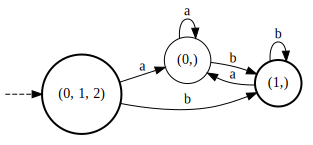

In [4]:
display(c.to_deterministic())

La clase `State` brinda el método `from_nfa` por compatibilidad con la API de autómatas que estuvimos usando hasta la clase anterior. Este método construye una instancia de `State` a partir de una instancia de `NFA` (o por tanto de `DFA`). Se puede incluir un segundo argumento al llamado del método `from_nfa` si se desea obtener, además del estado inicial del autómata resultante, el resto de los estados que fueron creados.

Original (DFA):


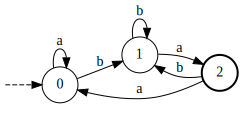

Copia (State):


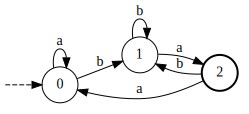

In [5]:
from cmp.tools.automata import DFA

automaton = DFA(states=3, finals=[2], transitions={
    (0, 'a'): 0,
    (0, 'b'): 1,
    (1, 'a'): 2,
    (1, 'b'): 1,
    (2, 'a'): 0,
    (2, 'b'): 1,
})
print('Original (DFA):')
display(automaton)

automaton = State.from_nfa(automaton)
print('Copia (State):')
display(automaton)

Además, se provee un mecanismo de reconocimiento de cadenas (independientemente de si el autómata subyacente es determinista o no). Este es accesible a través del método `<state>.recognize(string)`.

In [6]:
assert automaton.recognize('ba')
assert automaton.recognize('aababbaba')

assert not automaton.recognize('')
assert not automaton.recognize('aabaa')
assert not automaton.recognize('aababb')

## Generador de Lexer

Como estudiamos en conferencia, el generador de lexer se basa en un conjunto de expresiones regulares. Cada una de ellas está asociada a un tipo de token. El lexer termina siendo un autómata finito determinista con ciertas peculiaridades:
- Resulta de transformar el autómata unión entre todas las expresiones regulares del lenguaje, y convertirlo a determinista.
- Cada estado final almacena los tipos de tokens que se reconocen al alcanzarlo. Se establece una prioridad entre ellos para poder desambiaguar.
- Para tokenizar, la cadena de entrada viaja repetidas veces por el autómata.
    - Cada vez, se comienza por el estado inicial, pero se continúa a partir de la última sección de la cadena que fue reconocida.
    - Cuando el autómata se "traba" durante el reconocimiento de una cadena, se reporta la ocurrencia de un token. Su lexema está formado por la concatenación de los símbolos que fueron consumidos desde el inicio y hasta pasar por el último estado final antes de trabarse. Su tipo de token es el de mayor relevancia entre los anotados en el estado final.
    - Al finalizar de consumir toda la cadena, se reporta el token de fin de cadena.

### Expresiones regulares

El engine de expresiones regulares que implementamos en la clase anterior está disponible en `cmp.tool.regex`. La clase `Regex` se instancia a partir de un string que representa la expresión regular. Cada instancia posee un campo `automaton` que permite acceder al `DFA` que reconoce el lenguaje denotado por dicha expresión regular. Las instancias de `Regex` son invocables, recibiendo como único parámentro un string, y devuelve si el string pertenece o no al lenguaje denotado por la expresión regular.

In [7]:
from cmp.tools.regex import Regex

### Lexer

Implementemos el generador de lexer. El lexer se construirá a partir de la tabla de expresiones regulares (una lista de tuplas con la forma: `(<token_type>, <regex_str>)`). Esta tabla se recibe como el parámetro `table` en el contructor de la clase `Lexer`. La prioridad/relevancia de cada tipo de token está marcada por el índice que ocupa en la tabla. Los tipos de tokens cuyas expresiones regulares estén registradas más cerca del inicio de la tabla tiene más prioridad.
- **_build_regexs:** devuelve un lista con los autómatas (instancias de `State`) de cada expresión regular. Los estados finales de los respectivos autómatas deben marcarse (campo `tag`) con la prioridad y tipo de token según la expresión regular que lo originó.
- **_build_automaton:** devuelve la versión determinista del autómata que reconoce los tokens del lenguaje.
- **_walk:** Devuelve el último estado final visitado, y lexema consumido, durante el reconocimiento del string que se recibe como entrada.
- **_tokenize:** Devuelve tuplas de la forma `(lex, token_type)` que resultan de tokenizar la entrada. Debe manejar el caso en que la entrada no puede ser tokenizada completamente (se detecta cuando en una iteración la cadena no avanzó).

In [11]:
from cmp.utils import Token

class Lexer:
    def __init__(self, table, eof):
        self.eof = eof
        self.regexs = self._build_regexs(table)
        self.automaton = self._build_automaton()
    
    def _build_regexs(self, table):
        regexs = []
        for n, (token_type, regex) in enumerate(table):
            # Your code here!!!
            # - Remember to tag the final states with the token_type and priority.
            # - <State>.tag might be useful for that purpose ;-)
            regex_aut, regex_aut_states= State.from_nfa(Regex(regex).automaton, get_states=True)
            for state in regex_aut_states:
                if state.final:
                    state.tag = (token_type, n)
            regexs.append(regex_aut)
        return regexs
    
    def _build_automaton(self):
        start = State('start')
        # Your code here!!!
        for aut in self.regexs:
            start.add_epsilon_transition(aut)
        
        return start.to_deterministic()
        
    def _walk(self, string):
        state = self.automaton
        final = state if state.final else None
        final_lex = lex = ''
            
        for symbol in string:
            # Your code here!!!
            if symbol in state.transitions:  # exists transition for symbol
                state = state.transitions[symbol][0]
                lex += symbol
                if state.final:
                    final = state
                    final_lex = lex
            else:
                break
        return final, final_lex
    
    def _tokenize(self, text):
        # Your code here!!!
        display(self.automaton)
        processed = 0
        while processed < len(text):
            final, final_lex = self._walk(text[processed:])    # get actual state and lex
            if final is None or len(final_lex) == 0:
                raise Exception('Invalid token at position', processed + 1)
            processed += len(final_lex)
            pos_ret = []
            for s in final.state:
                if s.tag is not None:
                    pos_ret.append(s)
            ret = pos_ret[0]
            for i in range(1, len(pos_ret)):
                if pos_ret[i].tag[1] < ret.tag[1]:
                    ret = pos_ret[i]
            yield final_lex, ret.tag[0]

        yield '$', self.eof
    
    def __call__(self, text):
        return [ Token(lex, ttype) for lex, ttype in self._tokenize(text) ]

Construyamos un lexer con algunas expresiones regulares solo para comprobar la validez de la implementación. Usaremos `str` para marcar los tipos de tokens, pero recuerde que realmente se usan los símbolos de la gramática ya que son los símbolos con los que trabaja el parser.

Non-zero digits: 1|2|3|4|5|6|7|8|9
Letters: a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z

>>> Tokenizando: "5465 for 45foreach fore"


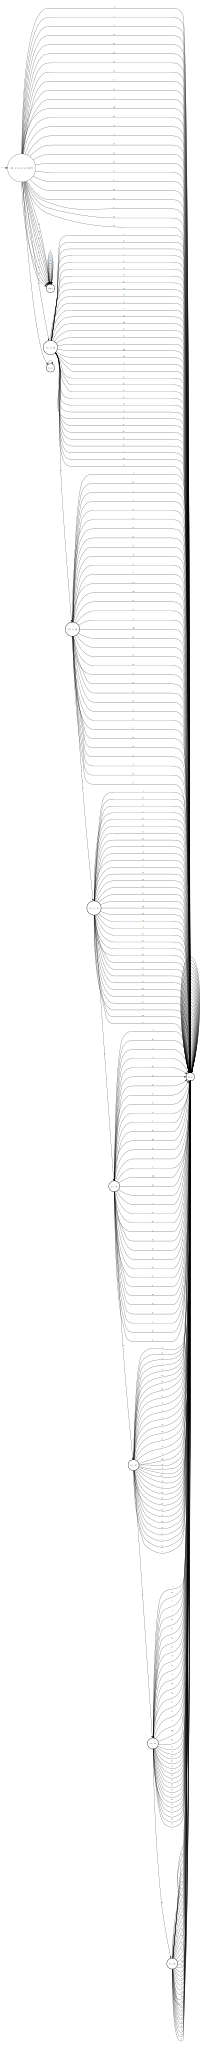

[num: 5465, space:  , for: for, space:  , num: 45, foreach: foreach, space:  , id: fore, eof: $]

>>> Tokenizando: "4forense forforeach for4foreach foreach 4for"


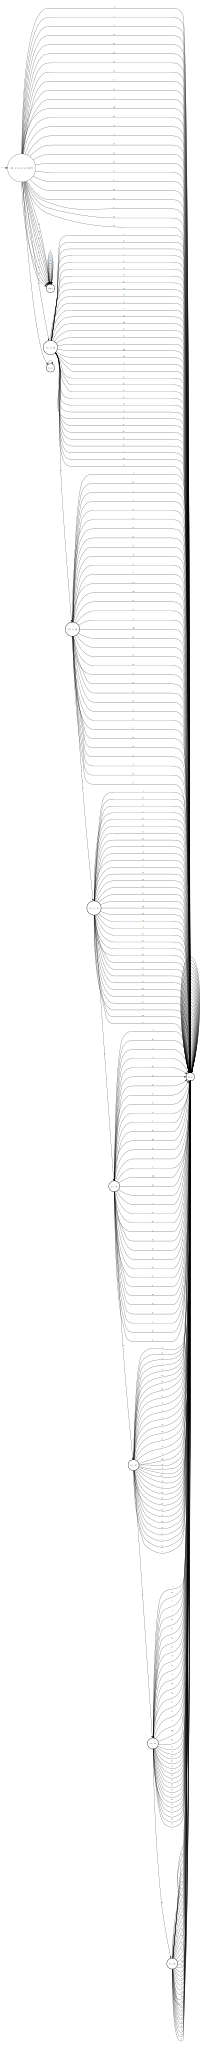

[num: 4, id: forense, space:  , id: forforeach, space:  , id: for4foreach, space:  , foreach: foreach, space:  , num: 4, for: for, eof: $]


In [12]:
nonzero_digits = '|'.join(str(n) for n in range(1,10))
letters = '|'.join(chr(n) for n in range(ord('a'),ord('z')+1))

print('Non-zero digits:', nonzero_digits)
print('Letters:', letters)

lexer = Lexer([
    ('num', f'({nonzero_digits})(0|{nonzero_digits})*'),
    ('for' , 'for'),
    ('foreach' , 'foreach'),
    ('space', '  *'),
    ('id', f'({letters})({letters}|0|{nonzero_digits})*')
    ], 'eof')

text = '5465 for 45foreach fore'
print(f'\n>>> Tokenizando: "{text}"')
tokens = lexer(text)
print(tokens)

assert [t.token_type for t in tokens] == ['num', 'space', 'for', 'space', 'num', 'foreach', 'space', 'id', 'eof']
assert [t.lex for t in tokens] == ['5465', ' ', 'for', ' ', '45', 'foreach', ' ', 'fore', '$']

text = '4forense forforeach for4foreach foreach 4for'
print(f'\n>>> Tokenizando: "{text}"')
tokens = lexer(text)
print(tokens)

assert [t.token_type for t in tokens] == ['num', 'id', 'space', 'id', 'space', 'id', 'space', 'foreach', 'space', 'num', 'for', 'eof']
assert [t.lex for t in tokens] == ['4', 'forense', ' ', 'forforeach', ' ', 'for4foreach', ' ', 'foreach', ' ', '4', 'for', '$']

## Propuestas

- Genere un lexer para el lenguaje _xCOOL_ que estuvimos trabajando a inicios del curso.
- Implemente un algoritmo para eliminar los estados muertos de un autómata. Recordemos que esto es conveniente puesto que de esta forma el autómata del lexer detecta los tokens más de prisa.